# Inference: Delayed Rejection Adaptive Covariance MCMC

This example shows you how to perform Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mc.html).

c:\users\bclamber\desktop\pints\pints\_mcmc\_dram_ac.py:127: RuntimeWarning: invalid value encountered in double_scalars
  alpha_log = log_Y[n + 1] - log_Y[0]
c:\users\bclamber\desktop\pints\pints\_mcmc\_dram_ac.py:145: RuntimeWarning: divide by zero encountered in log
  i, Y_rev[0:(i + 2)], log_Y_rev[0:(i + 2)]))) -


Running...
Done!
R-hat:
[77880920754567.625, 156054974717881.78, 2438272703296813.5]


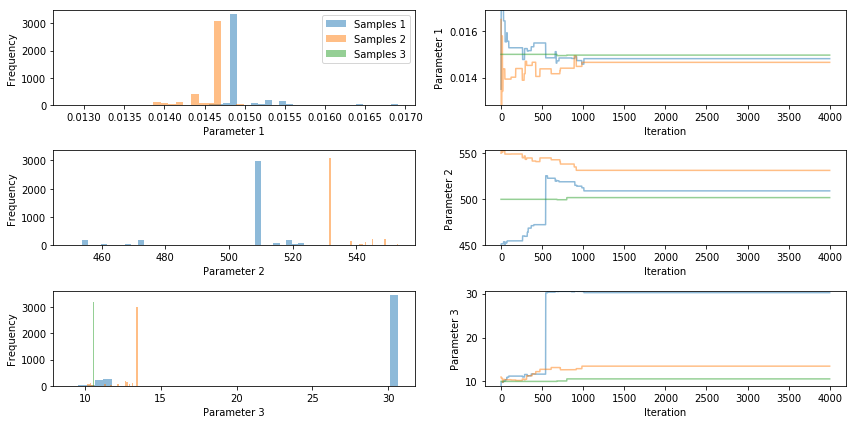

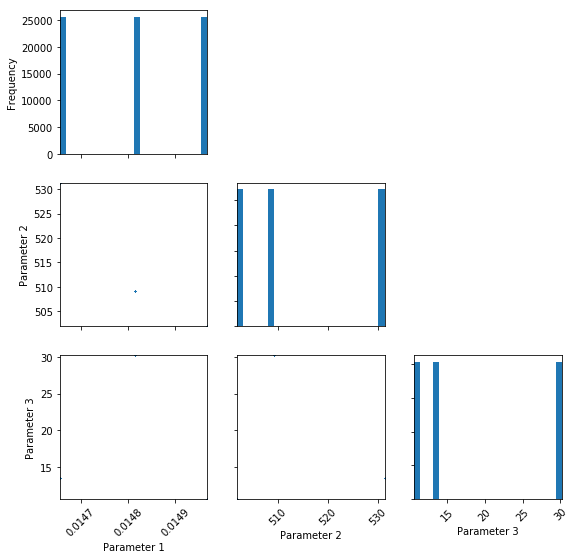

In [5]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    real_parameters * 0.9,
    real_parameters * 1.1,
    real_parameters,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.DramACMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Try 3 proposal kernels
# for i in range(len(xs)):
#     mcmc.samplers()[i].set_n_kernels(2)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Look at distribution across all chains
pints.plot.pairwise(np.vstack(chains), kde=False)

# Show graphs
plt.show()